In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import itertools
import scipy.io as sio
from tensorflow.python.ops import rnn, rnn_cell
#np.set_printoptions(threshold=np.inf)
import csv

In [2]:
slp03_matfile = "slp03m"
slp03_annotationfile = "slp03_annotation"

In [3]:
#variables for sensor data
ecg = []
bp = []
eeg = []
resp = []

#variables for annotation data
time = []
sample_num = []
sleep_stage = []

In [4]:
def read_mat(filename, num_data,ecg, bp, eeg, resp):
    mat_contents = sio.loadmat('data/'+filename+'.mat')
    val = mat_contents['val']
    ecg.append(val[0])
    bp.append(val[1])
    eeg.append(val[2])
    resp.append(val[3])
    for i in range(1,num_data):
        mat_contents = sio.loadmat('data/'+filename+' (%d).mat'% i)
        val = mat_contents['val']
        ecg.append(val[0])
        bp.append(val[1])
        eeg.append(val[2])
        resp.append(val[3])

In [5]:
def convert_sleep_stage_To_binary(sleep_stage):
    sleep_stage_label = ['W','R','1','2','3','4'] #id-> char
    sleep_stage_dic = {w: i for i, w in enumerate(sleep_stage_label)} # char->id
    indexed_sleep_stage = [sleep_stage_dic[c] for c in sleep_stage]
    binary_sleep_stage = np.zeros((len(indexed_sleep_stage), len(sleep_stage_label)))
    for j in range(0,len(indexed_sleep_stage)):
        binary_sleep_stage[j][indexed_sleep_stage[j]] = 1.
    return binary_sleep_stage # to index

In [6]:
def read_anno(filename, time, sample_num, sleep_stage):
    filename = "data/"+filename+".csv"
    with open(filename,newline='',encoding = 'utf-8') as csvfile:
        reader = csv.reader (csvfile)
        next(reader, None)
        for row in reader:
            time.append(row[0])
            sample_num.append(int(row[1]))
            sleep_stage.append(row[6])

In [7]:
def model(X, W, B, lstm_size):
    # X, input shape: (batch_size = 711, time_step_size = 7500, input_vec_size = 4)
    XT = tf.transpose(X, [1, 0, 2])  # permute time_step_size and batch_size
    # XT shape: (time_step_size, batch_size, input_vec_size)
    XR = tf.reshape(XT, [-1, lstm_size]) 
    # each row has input for each lstm cell (lstm_size=input_vec_size)
    # XR shape: (time_step_size * batch_size, input_vec_size)
    X_split = tf.split(0, time_step_size, XR)
    # split them to time_step_size (28 arrays)
    # Each array shape: (batch_size, input_vec_size)

    # Make lstm with lstm_size (each input vector size)
    lstm = tf.nn.rnn_cell.BasicLSTMCell(lstm_size, forget_bias=1.0, state_is_tuple=True)

    # Get lstm cell output, time_step_size (7500) arrays with lstm_size output: (batch_size, lstm_size)
    outputs, _states = tf.nn.rnn(lstm, X_split, dtype=tf.float32)

    # Linear activation
    # Get the last output
    return tf.matmul(outputs[-1], W) + B, lstm.state_size # State size to initialize the stat

In [8]:
def init_weights(shape):
    return tf.Variable(tf.random_normal(shape, stddev=0.01))

In [9]:
read_mat(slp03_matfile, 6, ecg, bp, eeg, resp)

In [10]:
ecg = list(itertools.chain(*ecg))
bp = list(itertools.chain(*bp))
eeg = list(itertools.chain(*eeg))
resp = list(itertools.chain(*resp))

In [11]:
#30초마다 한번씩 샘플링됨
read_anno(slp03_annotationfile, time, sample_num, sleep_stage)

In [12]:
print(sleep_stage)
print(len(sleep_stage))

['2', '2', '2', '2', 'W', '1', 'W', '1', '1', '1', '1', 'W', '1', '1', 'W', 'W', '1', '1', '1', '1', '1', '1', '2', '2', '2', '1', '1', '1', '1', '1', '1', '1', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', 'R', 'W', '1', '1', 'R', 'R', 'R', 'R', 'R', '1', 'R', 'R', 'R', 'R', '1', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', '1', '1', 'R', '1', 'R', 'R', '1', 'R', 'R', 'R', '1', '1', '1', 'R', 'R', 'R', '1', 'R', '1', 'R', '1', '1', 'R', '1', 'R', 'R', 'R', 'R', '1', '1', '1', '1', '1', '1', '2', '2', '2', '2', '1', '2', '2', '2', '2', '2', '1', '2', '2', '1', '2', '2', '1', '1', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', '1', '1', '1', '1', '1', '1',

In [13]:
print(sample_num[-1])
print(sample_num[0]-7500)
sample_num[-1]-(sample_num[0]-7500)

5392500
60000


5332500

In [14]:
def convert_to_quarter_size(ecg, bp, eeg,resp, sampling_num):
    temp_ecg = [ecg[4*i+sampling_num] for i in range(0,int(len(ecg)/4))]
    temp_bp = [bp[4*i+sampling_num] for i in range(0,int(len(bp)/4))]
    temp_eeg = [eeg[4*i+sampling_num] for i in range(0,int(len(eeg)/4))]
    temp_resp = [resp[4*i+sampling_num] for i in range(0,int(len(resp)/4))]
    return temp_ecg, temp_bp, temp_eeg, temp_resp

In [15]:
def sync_sample(sample_num, ecg, bp, eeg, resp):
    temp_ecg = ecg[sample_num[0]-7500:sample_num[-1]]
    temp_bp = bp[sample_num[0]-7500:sample_num[-1]]
    temp_eeg = eeg[sample_num[0]-7500:sample_num[-1]]
    temp_resp = resp[sample_num[0]-7500:sample_num[-1]]
    return temp_ecg, temp_bp, temp_eeg, temp_resp

In [16]:
ecg, bp, eeg, resp = sync_sample(sample_num, ecg, bp, eeg, resp)
q0_ecg,q0_bp,q0_eeg,q0_resp = convert_to_quarter_size(ecg, bp, eeg, resp, 0)
q1_ecg,q1_bp,q1_eeg,q1_resp = convert_to_quarter_size(ecg, bp, eeg, resp, 1)
q2_ecg,q2_bp,q2_eeg,q2_resp = convert_to_quarter_size(ecg, bp, eeg, resp, 2)
q3_ecg,q3_bp,q3_eeg,q3_resp = convert_to_quarter_size(ecg, bp, eeg, resp, 3)

In [17]:
print(len(ecg))
print(len(q0_ecg))
print(len(q1_bp))
print(len(q2_eeg))
print(len(q3_resp))

5332500
1333125
1333125
1333125
1333125


In [18]:
def pool_data(q0,q1,q2,q3):
    return q0+q1+q2+q3

In [19]:
def zip_sensor(ecg, bp, eeg, resp):
    return [list(i) for i in zip(ecg, bp, eeg, resp)]

In [20]:
input_ecg = pool_data(q0_ecg,q1_ecg,q2_ecg,q3_ecg)
input_bp = pool_data(q0_bp,q1_bp,q2_bp,q3_bp)
input_eeg = pool_data(q0_eeg,q1_eeg,q2_eeg,q3_eeg)
input_resp = pool_data(q0_resp,q1_resp,q2_resp,q3_resp)
input_sleep_stage = pool_data(sleep_stage,sleep_stage,sleep_stage,sleep_stage)

In [21]:
out_ecg = q0_ecg[:1875*2*60]
out_bp = q0_bp[:1875*2*60]
out_eeg = q0_eeg[:1875*2*60]
out_resp = q0_resp[:1875*2*60]
out_sleep_stage = sleep_stage[:1*2*60] # 60 minutes

In [22]:
#variables for RNN
input_vec_size = lstm_size = 4 # 4 sensors
batch_size = 711*4 # four sample
test_size = len(out_sleep_stage)
time_step_size = int((1*250*30)/4) # 250sample/sec*4 *30sec 
temp_data = zip_sensor(input_ecg,input_bp,input_eeg,input_resp)
temp_outdata = zip_sensor(out_ecg,out_bp,out_eeg,out_resp)
x_data = np.array(temp_data,dtype='float32')
x_outdata = np.array(temp_outdata,dtype='float32')

In [23]:
binary_sleep_stage = convert_sleep_stage_To_binary(input_sleep_stage)
binary_out_sleep_stage = convert_sleep_stage_To_binary(out_sleep_stage)
print(binary_sleep_stage)

[[ 0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.]
 ..., 
 [ 1.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.]]


In [24]:
print(x_data)

[[ -43.  107.  -17.   57.]
 [ -41.   71.   -2.   56.]
 [ -39.   40.   18.   56.]
 ..., 
 [ -46.  -17.    6. -248.]
 [ -69.    7.   16. -240.]
 [ -52.   61.   24. -243.]]


In [25]:
trX, trY, teX, teY = x_data, binary_sleep_stage, x_outdata, binary_out_sleep_stage
trX = trX.reshape(-1, 1875, 4)
teX = teX.reshape(-1, 1875, 4)

X = tf.placeholder("float", [None, 1875, 4]) # 1875 = 7500/4
Y = tf.placeholder("float", [None, 6])

# get lstm_size and output 10 labels
W = init_weights([lstm_size, 6])
B = init_weights([6])

py_x, state_size = model(X, W, B, lstm_size)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(py_x, Y))
train_op = tf.train.RMSPropOptimizer(0.001, 0.9).minimize(cost)
predict_op = tf.argmax(py_x, 1)
print("session ready")

session ready


In [27]:
session_conf = tf.ConfigProto()
session_conf.gpu_options.allow_growth = True

# Launch the graph in a session
with tf.Session(config=session_conf) as sess:
    # you need to initialize all variables
    tf.global_variables_initializer().run()

    for i in range(1000):
        for start, end in zip(range(0, len(trX), batch_size), range(batch_size, len(trX)+1, batch_size)):
            sess.run(train_op, feed_dict={X: trX[start:end], Y: trY[start:end]})

        test_indices = np.arange(len(teX))  # Get A Test Batch
        np.random.shuffle(test_indices)
        test_indices = test_indices[0:test_size]

        if (i%100 == 0 ):
            print(i, np.mean(np.argmax(teY[test_indices], axis=1) ==
                             sess.run(predict_op, feed_dict={X: teX[test_indices]})))

0 0.3
100 0.4
200 0.441666666667
300 0.441666666667
400 0.441666666667


KeyboardInterrupt: 

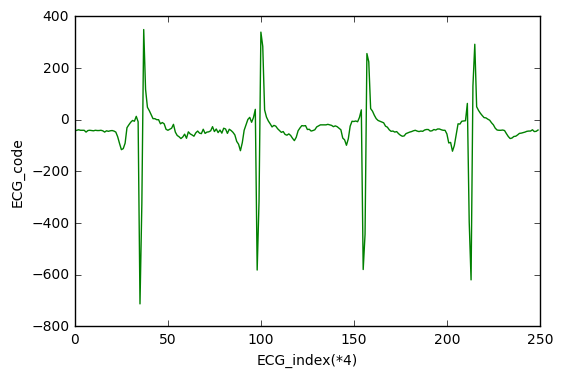

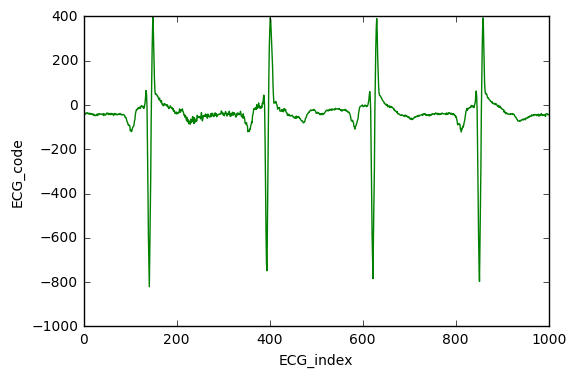

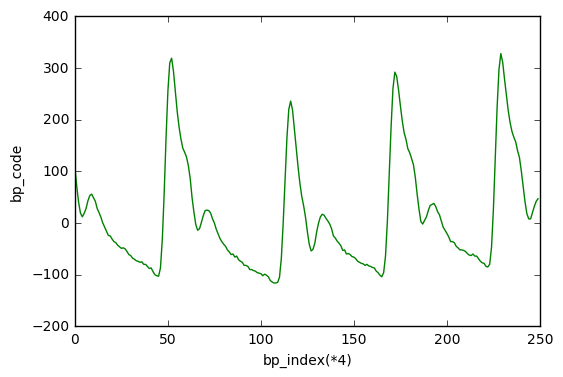

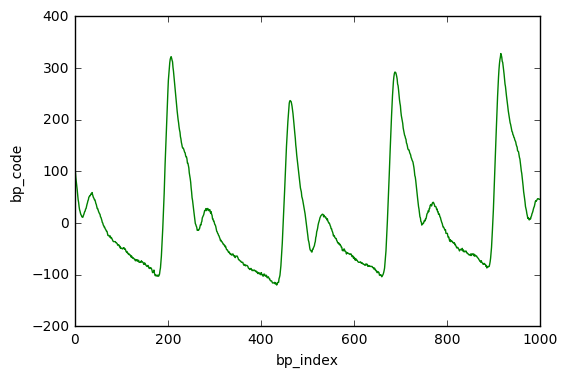

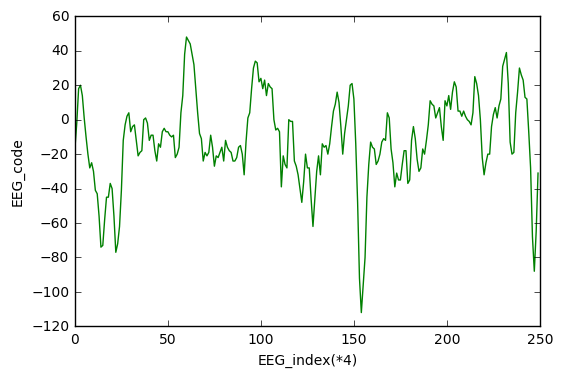

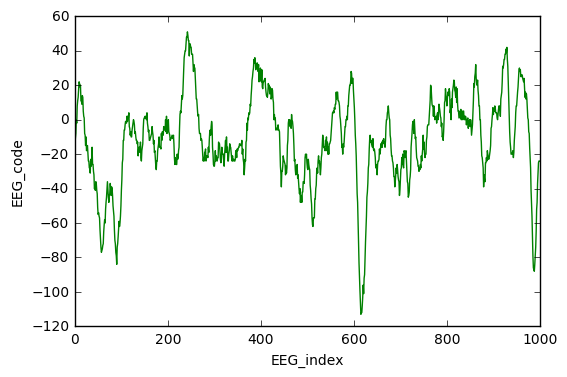

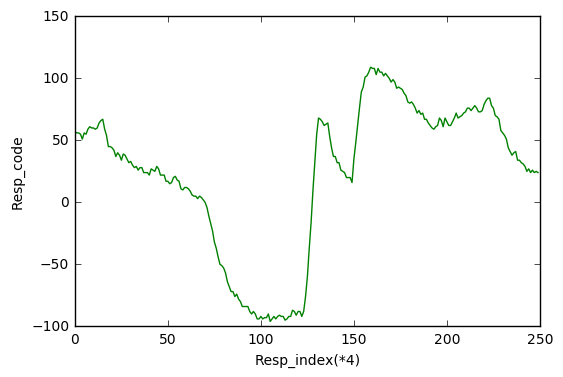

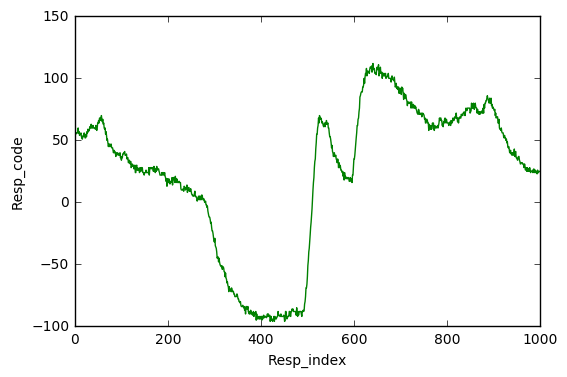

In [32]:
plt.plot(q0_ecg[:250],'g-')
plt.xlabel('ECG_index(*4)')
plt.ylabel('ECG_code')
plt.show()
plt.plot(ecg[:1000],'g-')
plt.xlabel('ECG_index')
plt.ylabel('ECG_code')
plt.show()
plt.plot(q0_bp[:250],'g-')
plt.xlabel('bp_index(*4)')
plt.ylabel('bp_code')
plt.show()
plt.plot(bp[:1000],'g-')
plt.xlabel('bp_index')
plt.ylabel('bp_code')
plt.show()
plt.plot(q0_eeg[:250],'g-')
plt.xlabel('EEG_index(*4)')
plt.ylabel('EEG_code')
plt.show()
plt.plot(eeg[:1000],'g-')
plt.xlabel('EEG_index')
plt.ylabel('EEG_code')
plt.show()
plt.plot(q0_resp[:250],'g-')
plt.xlabel('Resp_index(*4)')
plt.ylabel('Resp_code')
plt.show()
plt.plot(resp[:1000],'g-')
plt.xlabel('Resp_index')
plt.ylabel('Resp_code')
plt.show()